In [1]:
from itertools import product
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import scipy

import warnings
warnings.filterwarnings("ignore")

# NOTE: Whenever lambda functions are used, we create default variables when accessing
# outside variables. This is explained here: https://docs.python.org/3/faq/programming.html#id11

In [192]:
%load_ext snakeviz

### Helper functions

In [171]:
def emp_wasserstein2(u: np.array, v: np.array):
    """
    Returns the squared 2-Wasserstein distance between two
    empirical distributions represented by arrays.
    Assumes the arrays of equal size and are sorted.
    """
    # assert len(u) == len(v)
    
    # u_sorted = np.sort(u)
    # v_sorted = np.sort(v)
    u_sorted = u
    v_sorted = v
    
    return np.sum(np.power(u_sorted - v_sorted,2)) / len(u)

# def adjusted_emp_wasserstein2(u: np.array, v: np.array):
#     assert len(u) == len(v)
#     n = len(u)
    
#     u1 = u[:n // 2]
#     u2 = u[n // 2 :]
#     v1 = v[:n // 2]
#     v2 = v[n // 2 :]

#     w1_1 = emp_wasserstein2(u1, v1)
#     w1_2 = emp_wasserstein2(u1, v2)
#     w1_3 = emp_wasserstein2(u2, v1)
#     w1_4 = emp_wasserstein2(u2, v2)
    
#     w2 = emp_wasserstein2(u1, u2)
#     w3 = emp_wasserstein2(v1, v2)
#     m = n // 2
#     return ((w1_1 + w1_2 + w1_3 + w1_4) / 4) - (0.5 * (w2 + w3))
    

def dissim(list1: list[np.array], list2: list[np.array]) -> float:
    """
    Returns a dissimilarity measure between two lists of
    data arrays. Only measures dissimilarity between
    lists that are observed.
    
    If no observations overlap then returns infinity.
    Else returns the average 2-wasserstein distance.
    """
    size = 0
    distance = 0
    for ind in range(len(list1)):
        if len(list1[ind]) == 1 and len(list2[ind]):
            distance += (list1[ind][0] - list2[ind][0]) ** 2
        else:
            # distance += adjusted_emp_wasserstein2(list1[ind], list2[ind]) # unbiased
            distance += emp_wasserstein2(list1[ind],list2[ind]) # biased
        size += 1
    if size == 0:
        return float('inf')
    return distance / size

def get_col(table, col):
    """
    Utility function to get the column of a table
    as a 1-dim list.
    """
    return [table[i][col] for i in range(len(table))]

def barycenter(lists: list[np.array]):
    """
    Returns the barycenter of a list of empirical distributions
    with the same number of samples.
    
    This is just the average of the order statistics of
    each empirical distribution.
    
    Assumes the arrays are of equal length and sorted.
    """
    # for i in range(len(lists)):
    #     for j in range(i+1,len(lists)):
    #         assert len(lists[i]) == len(lists[j])
    
    # sorted_data = [np.sort(l) for l in lists]
    sorted_data = lists
    
    sum_data = 0
    for l in sorted_data:
        sum_data += l
    
    return sum_data / len(lists)

The 2-Wasserstein metric has a closed-form solution in the 1-dimensional case:

$$W_2(\mu_1,\mu_2) = \left(\int_0^1 \left|F^{-1}_1(q) - F^{-1}_2(q)\right|^2\right)^{1/2}$$

where $F^{-1}_1$ and $F^{-1}_2$ are quantile functions for the distributions.

In [156]:
from scipy.integrate import quad
from scipy.stats import norm
from functools import partial
from numpy import quantile

def wasserstein2(inv_cdf1, inv_cdf2):
    """
    Compute the squared 2-Wasserstein metric.
    """
    # Combine the inner part of the integral into one function
    # Estimate integral via quadrature
    y, _ = quad(lambda x : np.power((inv_cdf1(x) - inv_cdf2(x)), 2), 0, 1)
    return y

def wasserstein2_mc(ppf1, ppf2):
    N = 10000
    u = np.random.uniform(0,1,N)
    return np.sum(np.power(ppf1(u) - ppf2(u), 2)) / N

def empirical_quantile(data_arr):
    """
    Returns a function handle for the empirical quantile
    function given a 1-d dataset.
    """
    return lambda q, data_arr = data_arr : quantile(data_arr, q, method = 'inverted_cdf')

def normal_ppf(mean, std):
    return lambda q, mean = mean, std = std : norm.ppf(q, loc = mean, scale = std)

In [159]:
data = np.random.normal(0,1,100) # draw samples from N(0,1)
emp_quan = empirical_quantile(data) # create empirical quantile function
norm_ppf = normal_ppf(0,1) # percent point function (quantile function) of N(0,1)

y = wasserstein2(emp_quan, norm_ppf)

print(y)

0.09369351201351965


In [61]:
n = 100
error = []
ppf = lambda q: scipy.stats.norm.ppf(q,0,1)
for _ in tqdm(range(100)):
    data = np.random.normal(0,1,n // 2)
    y = wasserstein2(empirical_quantile(data), ppf)
    error.append(y)
    
np.mean(error)

100%|█████████████████████████████████████████| 100/100 [00:09<00:00, 10.41it/s]


0.05631102717180721

In [72]:
error_est = []
print(n)
for _ in tqdm(range(10000)):
    m = n //2
    data1 = np.random.normal(0,1,m)
    data2 = np.random.normal(0,1,m)
    error_est.append(emp_wasserstein2(data1, data2))
    
np.mean(error_est)

100


100%|██████████████████████████████████| 10000/10000 [00:00<00:00, 87673.21it/s]


0.10358618081837512

In [281]:
ppf1 = lambda q : scipy.stats.uniform.ppf(q, 0, 1)
ppf2 = lambda q : scipy.stats.uniform.ppf(q, 0, 5)

true_dist = wasserstein2(ppf1, ppf2)
print(f'True Squared W: {true_dist:.3f}')

for n in [2,4,8,10,100,1000,10000]:
    ests_biased = []
    ests_unbiased = []
    for _ in range(1000):
        data1 = ppf1(np.random.uniform(0,1,n)) # independent sample 1
        data2 = ppf2(np.random.uniform(0,1,n)) # independent sample 2
        
        ests_biased.append(emp_wasserstein2(data1, data2))
        ests_unbiased.append(adjusted_emp_wasserstein2(data1, data2))
        
    biased_error_rel = abs(true_dist - np.mean(ests_biased)) / true_dist
    unbiased_error_rel = abs(true_dist - np.mean(ests_unbiased)) / true_dist

    print(f'n: {n: <5}, Biased Rel Error: {biased_error_rel * 100 :.3f}%, Unbiased Rel Error: {unbiased_error_rel * 100:.3f}%')

True Squared W: 5.333
n: 2    , Biased Rel Error: 12.119%, Unbiased Rel Error: 23.567%
n: 4    , Biased Rel Error: 5.975%, Unbiased Rel Error: 17.874%
n: 8    , Biased Rel Error: 3.192%, Unbiased Rel Error: 10.239%
n: 10   , Biased Rel Error: 1.665%, Unbiased Rel Error: 9.818%
n: 100  , Biased Rel Error: 0.472%, Unbiased Rel Error: 0.871%
n: 1000 , Biased Rel Error: 0.131%, Unbiased Rel Error: 0.264%
n: 10000, Biased Rel Error: 0.032%, Unbiased Rel Error: 0.018%


-0.01843372015826582 0.9875565681761207 -0.00014269772110434787 0.9942565784701538
0.043259641599877365
0.012251823357599638


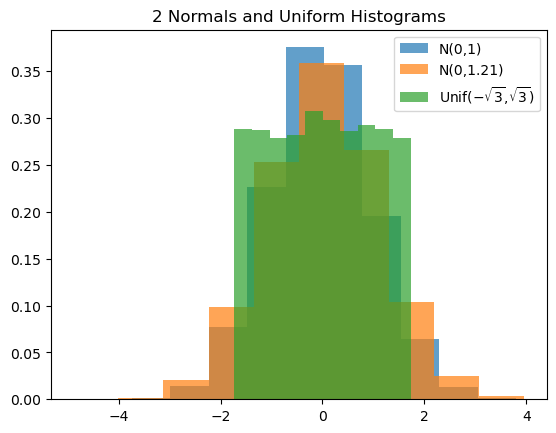

In [76]:
np.random.seed(0)
norm_data = np.random.normal(0,1,10000)
norm_data2 = np.random.normal(0,1.1,10000)
unif_data = np.random.uniform(-np.sqrt(3), np.sqrt(3), 10000)

print(np.mean(norm_data), np.std(norm_data), np.mean(unif_data), np.std(unif_data))
print(emp_wasserstein2(norm_data, unif_data))
print(emp_wasserstein2(norm_data, norm_data2))

alpha = 0.7
plt.hist(norm_data, alpha = alpha, density = True)
plt.hist(norm_data2, alpha = alpha, density = True)
plt.hist(unif_data, alpha = alpha, density = True)
plt.legend(["N(0,1)", "N(0,1.21)", "Unif($-\sqrt{3}$,$\sqrt{3}$)"])
plt.title("2 Normals and Uniform Histograms")
plt.savefig("normal_unif_wasserstein.pdf")
plt.show()

### Generate Data

In [12]:
m = 20
n = 20
s = 200

np.random.seed(0)

data_table = {}
true_dists = {}

# Table of n x m Gaussians with columns having same variance and rows having same means
mean_rows = np.random.uniform(-10,10, m)
std_cols = np.random.uniform(1,5,n)

for i in range(m):
    for j in range(n):
        data_table[i,j] = np.sort(np.random.normal(mean_rows[i], std_cols[j], s))
        true_dists[i,j] = normal_ppf(mean_rows[i], std_cols[j])
        
mask = (np.random.uniform(0,1,(m,n)) < 0.9).astype(int)

In [13]:
fig, axs = plt.subplots(m, n)

for i in range(m):
    for j in range(n):
        if mask[i,j] == 0:
            axs[i, j].hist(data_table[i,j], bins=s // 10, color = 'black')
        else:
            axs[i, j].hist(data_table[i,j], bins=s // 10, color = 'blue')

Error in callback <function flush_figures at 0x176f1ade0> (for post_execute):


KeyboardInterrupt: 

In [189]:
print("(row,col): mean, std\n")
for i, j in product(range(m),range(n)):
    print(f"({i}, {j}): {np.mean(data_table[i,j]):.2f}, {np.std(data_table[i,j]):.2f}")

(row,col): mean, std

(0, 0): 1.09, 3.58
(0, 1): 0.60, 2.60
(0, 2): 0.40, 4.72
(0, 3): 0.53, 4.72
(0, 4): 1.13, 2.37
(1, 0): 4.62, 3.40
(1, 1): 4.37, 2.66
(1, 2): 4.16, 4.51
(1, 3): 4.40, 4.90
(1, 4): 4.15, 2.35
(2, 0): 2.02, 3.58
(2, 1): 1.93, 2.58
(2, 2): 1.79, 4.40
(2, 3): 1.82, 4.67
(2, 4): 1.87, 2.28
(3, 0): 0.58, 3.69
(3, 1): 0.80, 2.77
(3, 2): 1.23, 4.68
(3, 3): 0.76, 4.97
(3, 4): 0.89, 2.55
(4, 0): -1.81, 3.64
(4, 1): -1.38, 2.68
(4, 2): -1.43, 4.61
(4, 3): -1.46, 4.79
(4, 4): -1.22, 2.50


In [243]:
# Dissimilarity between columns 0 and 1
dissim([data_table[i,0] for i in range(m)], [data_table[i,2] for i in range(m)])

4.186918344948787

In [244]:
# Dissimilarity between rows 0 and 1
dissim([data_table[0,j] for j in range(n)], [data_table[2,j] for j in range(n)])

1.171179993656651

### Wasserstein Barycenter

In [245]:
row1_bc = barycenter([data_table[i,1] for i in range(m)])

np.mean(row1_bc), np.std(row1_bc)

(1.6439049411341864, 4.0661216263620625)

In [314]:
def get_user_user_distances_fast(data_table, mask):
    samples = data_table.shape[2]
    data_table[mask == 0,:] = np.inf # mask values
    dists = np.power(data_table[:,None,:,:] - data_table, 2) # each pair of rows differenced
    row_dists = np.sum(dists, axis = 3) / samples
    row_dists[row_dists == np.inf] = 0
    np.nan_to_num(row_dists, copy = False, nan = 0)

    row_dists = np.sum(row_dists, axis = 2)
    
    row_dists[np.sum(mask[:,None,:] * mask, axis = 2) == 0] = np.inf
    np.fill_diagonal(row_dists, np.inf)

    return row_dists

def estimate_fast(data_table, mask, row, col, row_dists, eta):
    NN = row_dists < eta
    NN = NN[row]
    
    if len(NN) > 0:
        return np.mean(data_table[NN, col, :], axis = 0)
    else:
        data_masked = data_table * mask[:,:,None]
        return np.mean(data_masedk[:, col, :], axis = 0)

n_rows = 5
n_cols = 3
samples = 10

mean_rows = np.random.uniform(-5,5,n_rows)
std_cols = np.random.uniform(1,5,n_cols)

data_table = np.zeros((n_rows, n_cols, samples))
true_dists = {}

for i, j in product(range(n_rows), range(n_cols)):
    data_table[i,j,:] = np.sort(np.random.normal(mean_rows[i], std_cols[j], samples))
    true_dists[i,j] = normal_ppf(mean_rows[i], std_cols[j])

mask = np.array([
    [1, 1, 0],
    [1, 1, 1],
    [0, 0, 0],
    [1, 1, 0],
    [0, 0, 1]
])

data_table[mask == 0,:] = np.inf # mask values
data_table.shape

(5, 3, 10)

In [121]:
def get_user_user_distances(data_table, mask, n_rows, n_cols):
    d = {}
    
    for i in range(n_rows):
        for u in range(i,n_rows):
            overlap = {j for j in range(n_cols) if mask[i,j] == 1 and mask[u,j] == 1}
            # if no overlap or looking at the same user
            if i == u or len(overlap) == 0:
                d[i,u] = np.inf
                d[u,i] = np.inf
                continue
            # if overlap, then calcualte dissimilarity
            d[i,u] = dissim([data_table[i,j] for j in range(n) if j in overlap],
                            [data_table[u,j] for j in range(n) if j in overlap])
            d[u,i] = d[i,u]
    return d

def estimate(data_table, mask, row, col, eta, n_rows, n_cols, distances):
    NN = {k for k in range(n_rows) if distances[row, k] <= eta}
    avg_inds = {}
    if len(NN) > 0:
        avg_inds = NN
    else:
        avg_inds = {k for k in range(n_rows) if mask[k,col] == 1}
        
    return barycenter([data_table[k,col] for k in avg_inds])
    
# def MSE(est_data_table, true_dists, n, m, verbose = False):
#     mse = 0
#     loop = None
#     if verbose:
#         loop = tqdm(product(range(m), range(n)), total = m * n)
#     else:
#         loop = product(range(m), range(n))
#     for i, j in loop:
#         mse += wasserstein2_mc(empirical_quantile(est_data_table[i,j]), true_dists[i,j])
#     return mse / (n * m)

In [150]:
from sklearn.model_selection import train_test_split
from copy import deepcopy
from hyperopt import hp, tpe, fmin

def evaluate_eta(data_table, n_rows, n_cols, mask, k, eta):
    """
    Run cross validation on the dataset with a given eta.
    """
    observed_inds = np.array([(i,j) for i,j in product(range(n_rows), range(n_cols)) if mask[i,j] == 1])
    np.random.shuffle(observed_inds)
    chunks = np.array_split(observed_inds, k)
    error = 0
    
    for k_ind in range(k):
        test = chunks[k_ind] # left out
        train = np.concatenate([chunks[i] for i in range(k) if i != k_ind]) # everything else
        test_set = {tuple(t) for t in test}
        
        new_mask = deepcopy(mask)
        for i,j in product(range(n_rows), range(n_cols)):
            if (i,j) in test_set:
                new_mask[i,j] = 0
        dists = get_user_user_distances(data_table, new_mask, n_rows, n_cols)
        
        for i, j in product(range(n_rows), range(n_cols)):
            if (i,j) in test_set:
                est = estimate(data_table, mask, i,j, eta, n_rows, n_cols, dists)
                error += emp_wasserstein2(est, data_table[i,j])
                
    error /= len(observed_inds)
    return error

def search_eta(data_table, n_rows, n_cols, mask, k):
    """
    Search for an optimal eta using cross validation on
    the observed data.
    """
    def obj(eta):
        return evaluate_eta(data_table, n_rows, n_cols, mask, k, eta)
    
    best_eta = fmin(fn=obj, verbose = False, space=hp.uniform('eta', 0.001, 10.0), algo=tpe.suggest, max_evals=30)
    return best_eta['eta']

In [172]:
def simulate_nn_location_scale(M, N, n, n_runs):
    np.random.seed(0)
    error_est = []
    error_observed = []

    for _ in tqdm(range(n_runs)):
        data_table = {}
        true_dists = {}

        # Table of n x m Gaussians with columns having same variance and rows having same means
        mean_rows = np.random.uniform(-5,5,M)
        std_cols = np.random.uniform(1,5,N)
        
        for i, j in product(range(M), range(N)):
            data_table[i,j] = np.sort(np.random.normal(mean_rows[i], std_cols[j], n))
            true_dists[i,j] = normal_ppf(mean_rows[i], std_cols[j])

        mask = np.ones((M,N)).astype(int)
        mask[0,0] = 0
        
        eta = search_eta(data_table, M, N, mask, 3)
        
        est_data_table = {}

        d = get_user_user_distances(data_table, mask, M, N)
        est_data_table[0,0] = estimate(data_table, mask, 0,0, eta, M, N, d)
        
        error_est.append(wasserstein2(empirical_quantile(est_data_table[0,0]), true_dists[0,0]))
        error_observed.append(wasserstein2(empirical_quantile(data_table[0,0]), true_dists[0,0]))

    return error_est, error_observed

In [177]:
errors3 = {}

cols = [100]
rows = [100]
n_runs = 20
samples = [100]

for M, N, n in product(cols, rows, samples):
    print(M, N, n)
    errors3[(M, N, n)] = simulate_nn_location_scale(M, N, n, n_runs)

100 100 100


100%|██████████████████████████████████████████████████████████████| 20/20 [29:17<00:00, 87.90s/it]


In [178]:
import pickle

with open('errors3_loc_scale.pickle', 'wb') as handle:
    pickle.dump(errors3, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [179]:
errors.update(errors3)

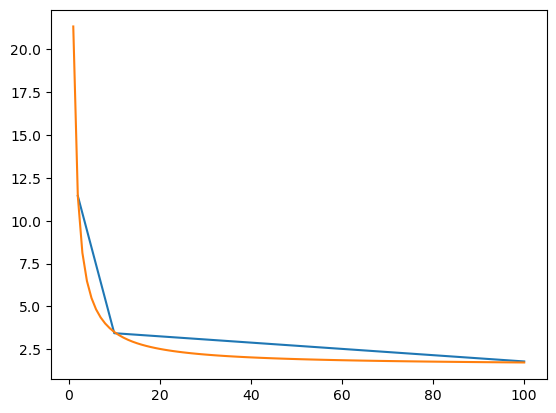

In [190]:
from scipy.optimize import curve_fit

def fit_func(x, a, b):
    return a*(1/x) + b

cols = [5, 20, 50, 100]
rows = [5, 20, 50, 100]
samples = [2, 10, 100]

errors_avg = {k: np.mean(v[0]) for k, v in errors.items()}
errors_std = {k: np.std(v[0]) for k, v in errors.items()}

x = samples
y = [np.mean([errors_avg[r, c, s] for r, c in product(rows, cols)]) for s in samples]
yerr = [np.mean([errors_std[r, c, s] for r, c in product(rows, cols)]) for s in samples]
plt.plot(x, y)

params = curve_fit(fit_func, x, y)
a,b = params[0]

plt.plot(range(1,101), [a * (1/x) + b for x in range(1,101)])

# Experiment 2 - DNN vs NN for averaging

In [27]:
m = 30
n = 30
s = 100

np.random.seed(0)

dnn_error = []
nn_error = []

for _ in tqdm(range(20)):
    data_table = {}
    data_table_avg = {}
    true_dists = {}

    # Table of n x m Gaussians with columns having same variance and rows having same means
    mean_rows = np.random.uniform(-10,10, m)
    std_cols = np.random.uniform(1,5, n)
    # std_cols = np.ones((n,1))

    for i, j in product(range(m), range(n)):
        data_unif = np.random.uniform(0,1, s)
        ppf = lambda q, mean = mean_rows[i], std = std_cols[j] : scipy.stats.norm.ppf(q, mean, std)
        data_table[i,j] = ppf(data_unif)
        true_dists[i,j] = ppf
        data_table_avg[i,j] = np.zeros(1) + np.mean(data_table[i,j])

    # mask = (np.random.uniform(0,1,(m,n)) < 0.9).astype(int)
    mask = np.ones((m,n)).astype(int)
    mask[0,0] = 0
    
    d = get_user_user_distances(data_table, mask, m, n)

    est_data_table = {}
    est_data_table_avg = {}
    
    eta_dist = search_eta(data_table, m, n, mask, 5)
    eat_avg = search_eta(data_table_avg, m, n, mask, 5)
    
    for i, j in product(range(m), range(n)):
        if mask[i,j] == 1:
            est_data_table[i,j] = data_table[i,j]
            est_data_table_avg[i,j] = data_table_avg[i,j]
        else:
            est_data_table[i,j] = estimate(data_table, mask, i,j, eta_dist, m, n, d)
            est_data_table_avg[i,j] = estimate(data_table_avg, mask, i,j, eat_avg, m, n, d)
    dnn_error.append((np.mean(est_data_table[0,0]) - mean_rows[0]) ** 2)
    nn_error.append((np.mean(est_data_table_avg[0,0]) - mean_rows[0]) ** 2)
    # print(f"True Mean: {mean_rows[0]:.5f}")
    # print(np.mean(est_data_table[0,0]), est_data_table_avg[0,0][0])
    # print(f'DNN: {(np.mean(est_data_table[0,0]) - mean_rows[0]) ** 2:.5f}')
    # print(f'NN : {(np.mean(est_data_table_avg[0,0]) - mean_rows[0]) ** 2:.5f}')
    
print(np.mean(dnn_error), np.mean(nn_error))

100%|██████████████████████████████████████████████████████████████| 20/20 [08:56<00:00, 26.81s/it]

3.4062223776866913 8.982229236841022


### Data Generating Model - Normal Means and Normal Different Variances
We will have the column space contain functions that map to normal distributions and the row space contain functions that map to uniform distributions. We will then combine them via a tensor product and see what we get.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


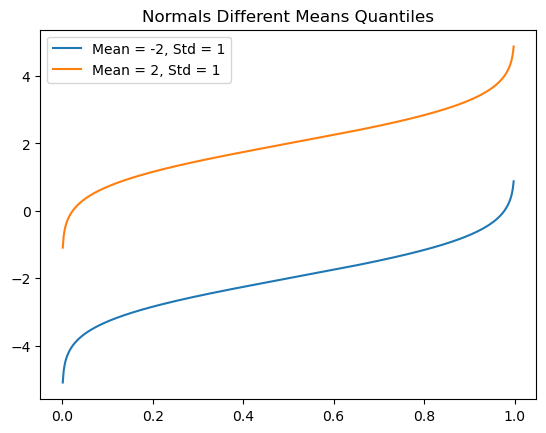

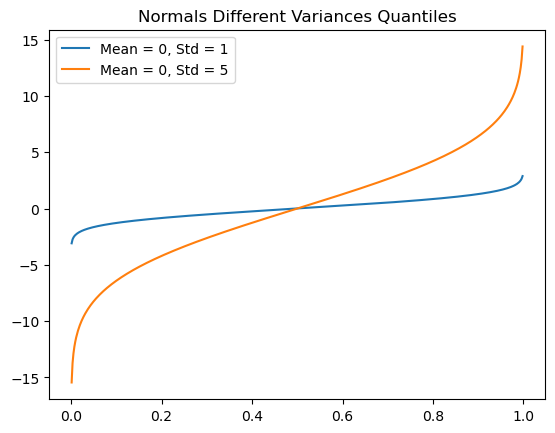

In [50]:
# Different means
mean_ppf_1 = lambda x : stats.norm.ppf(x, loc = -2, scale = 1)
mean_ppf_2 = lambda x : stats.norm.ppf(x, loc = 2, scale = 1)

# Different variances
var_ppf_1 = lambda x : stats.norm.ppf(x, loc = 0, scale = 1)
var_ppf_2 = lambda x : stats.norm.ppf(x, loc = 0, scale = 5)

x = np.linspace(-1,1,1000)
plt.figure()
plt.plot(x,mean_ppf_1(x))
plt.plot(x,mean_ppf_2(x))
plt.title("Normals Different Means Quantiles")
plt.legend(["Mean = -2, Std = 1", "Mean = 2, Std = 1"])
plt.savefig("normals_means.eps")
plt.figure()
plt.plot(x,var_ppf_1(x))
plt.plot(x,var_ppf_2(x))
plt.title("Normals Different Variances Quantiles")
plt.legend(["Mean = 0, Std = 1", "Mean = 0, Std = 5"])
plt.savefig("normals_stds.eps")
plt.show()

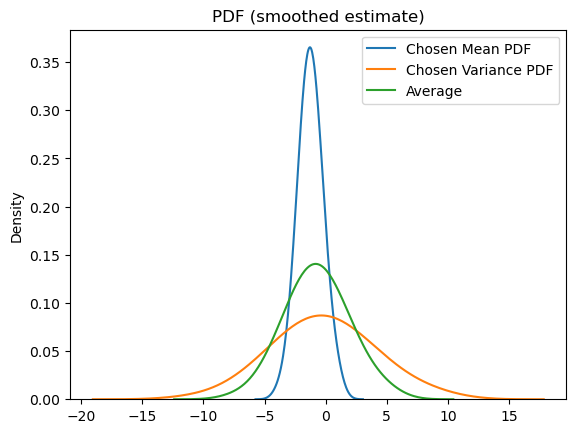

In [56]:
import seaborn as sns

# Interpolated functions back in the Wasserstein space
np.random.seed(0)
ref_samples = np.random.normal(0,1,1000)

bins = 100

sns.kdeplot(exp_map_empirical(f_mean_comb, ref_samples), bw_adjust=bw_adjust)
sns.kdeplot(exp_map_empirical(f_var_comb, ref_samples), bw_adjust=bw_adjust)
sns.kdeplot(exp_map_empirical(f_comb, ref_samples), bw_adjust=bw_adjust)

plt.title("PDF (smoothed estimate)")
plt.legend(["Chosen Mean PDF", "Chosen Variance PDF", "Average"])
plt.show()

### Data Table

In [51]:
# Let's create a dataset
num_rows = 3
num_cols = 3

t_row = [0, 0.1, 1]
t_col = [0, 0.1, 1]

row_log_f = []
col_log_f = []

for i in range(num_rows):
    row_log_f.append(interpolate(mean_f1, mean_f2, t_row[i]))
    
for j in range(num_cols):
    col_log_f.append(interpolate(var_f1, var_f2, t_col[j]))

log_f_table = {}

for i, j in product(range(num_rows), range(num_cols)):
    log_f_table[(i,j)] = lambda x, i = i, j = j : (row_log_f[i](x) + col_log_f[j](x)) * 0.5

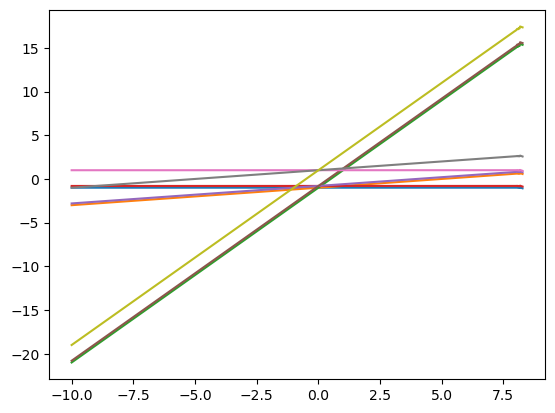

In [52]:
x = np.linspace(-10,10,1000)

for i, j in product(range(num_rows), range(num_cols)):
    plt.plot(x, log_f_table[i,j](x))

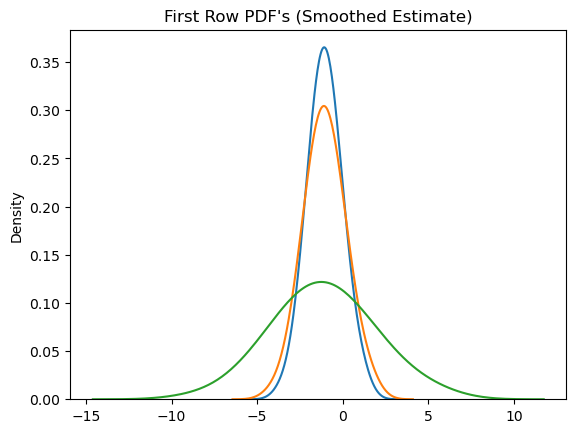

In [57]:
plt.title("First Row PDF's (Smoothed Estimate)")
for j in range(num_cols):
    sns.kdeplot(exp_map_empirical(log_f_table[0,j], ref_samples), bw_adjust=bw_adjust)
plt.show()

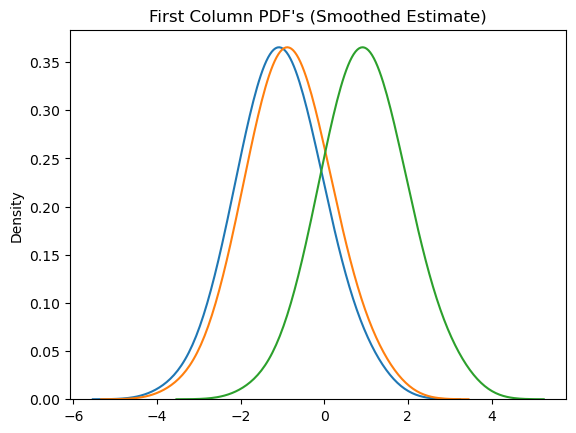

In [58]:
plt.title("First Column PDF's (Smoothed Estimate)")
for i in range(num_rows):
    sns.kdeplot(exp_map_empirical(log_f_table[i,0], ref_samples), bw_adjust=bw_adjust)
plt.show()

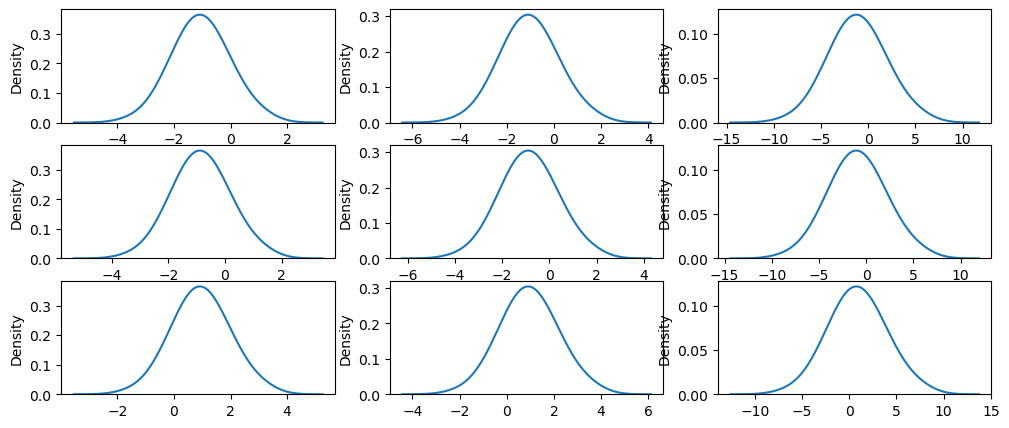

In [59]:
fig, axs = plt.subplots(num_rows, num_cols)
fig.set_figheight(5)
fig.set_figwidth(12)

for i, j in product(range(num_rows), range(num_cols)):
    sns.kdeplot(exp_map_empirical(log_f_table[i,j], ref_samples), ax = axs[i,j], bw_adjust=bw_adjust)
    
plt.show()

Here, we distribute the means and variances uniformly to show that we can generate this kind of dataset easily. This leads to now row or columns being similar, but shows how we can easily use geodesics to create a dataset of probability distributions.

With this generative model, we can create distributions with common aspects across rows and columns. These aspects are geodesics in the Wasserstein space and lines in the L2 space.

## Data Table with Normal and Exponential

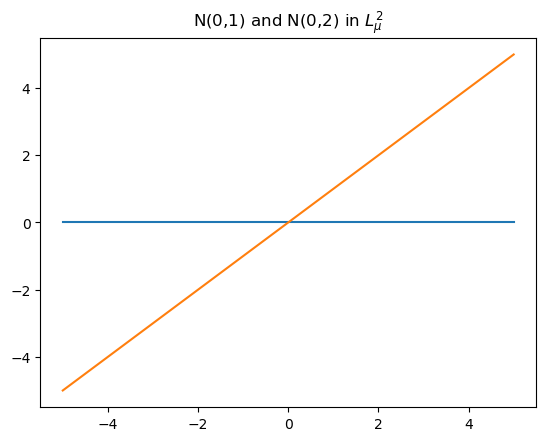

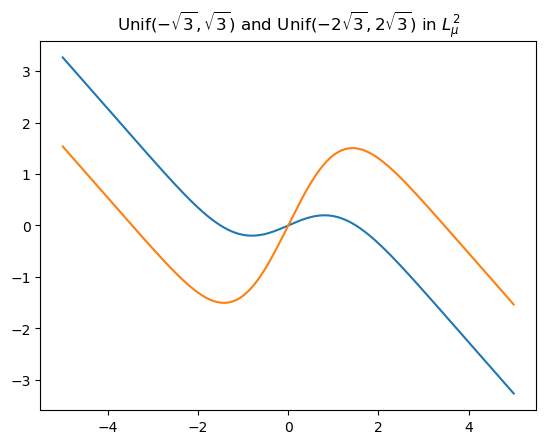

In [82]:
ref_cdf = lambda x : stats.norm.cdf(x, loc = 0, scale = 1) # N(0,1)

# Different Normals
norm_ppf_1 = lambda x : stats.norm.ppf(x, loc = 0, scale = 1)
norm_ppf_2 = lambda x : stats.norm.ppf(x, loc = 0, scale = 2)

# Different Uniforms
unif_ppf_1 = lambda x : stats.uniform.ppf(x, loc = -np.sqrt(3), scale = 2 * np.sqrt(3))
unif_ppf_2 = lambda x : stats.uniform.ppf(x, loc = -2 * np.sqrt(3), scale = 4 * np.sqrt(3))

norm_f1 = log_map(norm_ppf_1, ref_cdf)
norm_f2 = log_map(norm_ppf_2, ref_cdf)
unif_f1 = log_map(unif_ppf_1, ref_cdf)
unif_f2 = log_map(unif_ppf_2, ref_cdf)

x = np.linspace(-5,5,1000)
plt.figure()
plt.title("N(0,1) and N(0,2) in $L^2_\mu$")
plt.plot(x,norm_f1(x))
plt.plot(x,norm_f2(x))
plt.figure()
plt.title("Unif($-\sqrt{3},\sqrt{3}$) and Unif($-2\sqrt{3},2\sqrt{3}$) in $L^2_\mu$")
plt.plot(x,unif_f1(x))
plt.plot(x,unif_f2(x))

plt.show()

In [98]:
# Let's create a dataset
t_row = [0, 0.1, 1]
t_col = [0, 0.1, 1]

num_rows = len(t_row)
num_cols = len(t_col)

row_log_f = []
col_log_f = []

for i in range(num_rows):
    row_log_f.append(interpolate(norm_f1, unif_f1, t_row[i]))
    
for j in range(num_cols):
    col_log_f.append(interpolate(norm_f2, unif_f2, t_col[j]))

log_f_table = {}

for i, j in product(range(num_rows), range(num_cols)):
    log_f_table[(i,j)] = lambda x, i = i, j = j : (row_log_f[i](x) + col_log_f[j](x)) * 0.5

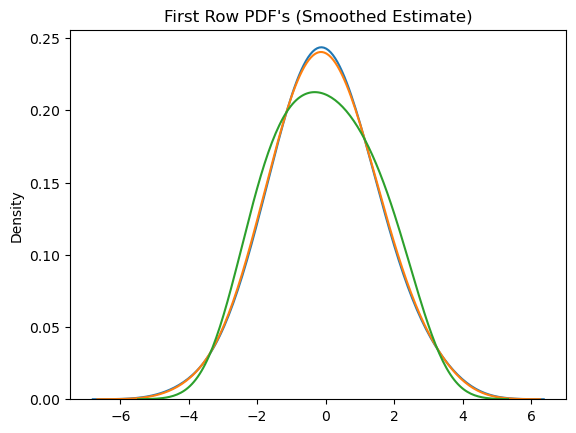

In [99]:
plt.title("First Row PDF's (Smoothed Estimate)")
for j in range(num_cols):
    sns.kdeplot(exp_map_empirical(log_f_table[0,j], ref_samples), bw_adjust=bw_adjust)
plt.show()

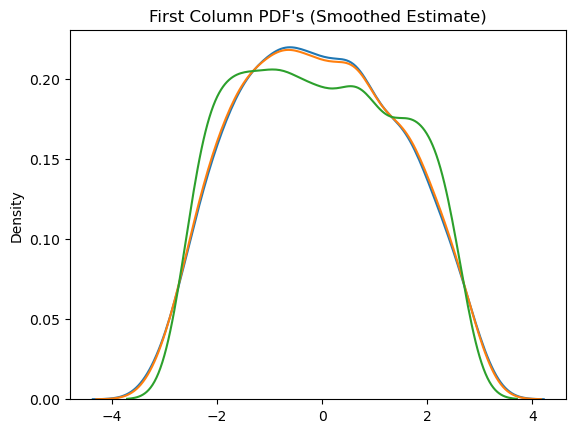

In [102]:
plt.title("First Column PDF's (Smoothed Estimate)")
for i in range(num_rows):
    sns.kdeplot(exp_map_empirical(log_f_table[i,2], ref_samples), bw_adjust=1)
plt.show()

In [107]:
data_table = [[0 for i in range(num_cols)] for j in range(num_rows)]
for i in range(num_rows):
    for j in range(num_cols):
        data_table[i][j] = exp_map_empirical(log_f_table[i,j], ref_samples)

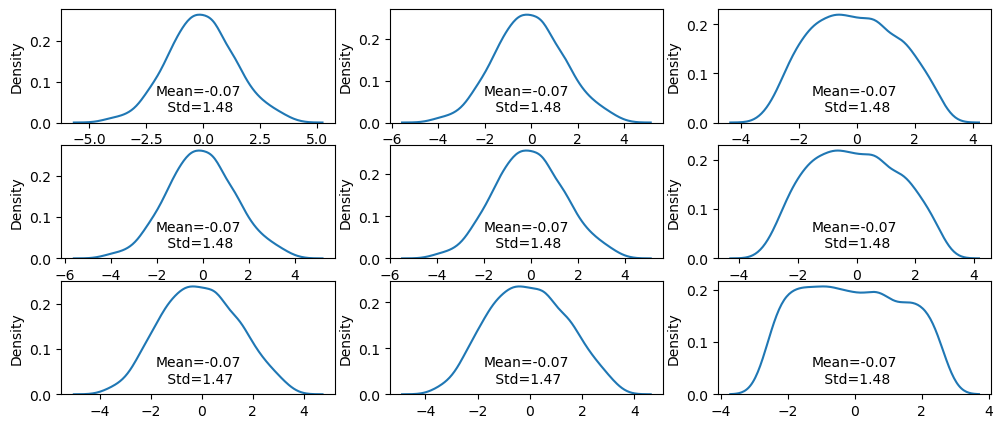

In [136]:
fig, axs = plt.subplots(num_rows, num_cols)
fig.set_figheight(5)
fig.set_figwidth(12)

for i, j in product(range(num_rows), range(num_cols)):
    data = data_table[i][j]
    sns.kdeplot(data, ax = axs[i,j], bw_adjust=1)
    axs[i,j].text(0.5,0.1, 
                  f'Mean={np.mean(data):.2f}\n Std={np.std(data):.2f}', 
                  ha='center', 
                  transform=axs[i,j].transAxes)
    
plt.savefig("data_table_unif_norm.pdf")
plt.show()

In [105]:
dissim(get_col(data_table, 0), get_col(data_table, 2))

0.04188484409478879

In [106]:
dissim(get_col(data_table, 0), get_col(data_table, 1))

0.0004188484409478877